In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from keras.models import model_from_json
import os
import pickle

Using TensorFlow backend.


In [2]:
# reading dataset - all official NBA matches from past 20 seasons
raw_dataset = pd.read_csv('~/nba-dl/data/dataset/realtime-1999-2019.csv')

In [3]:
# get dataset shape - rows, columns
raw_dataset.shape

(24480, 23)

In [4]:
# check for NaN values in dataset
raw_dataset.isnull().values.any()

False

In [5]:
# get dataset columns
raw_dataset.columns

Index(['SEASON_ID', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'HWIN', 'HPLUSMINUS', 'HPO', 'APO', 'HGLW', 'AGLW', 'HLGR', 'ALGR',
       'HLH2HR', 'ALH2HR', 'HTFR', 'ATFR', 'HSWR', 'ASWR', 'HSPS', 'ASPS',
       'HSPL', 'ASPL'],
      dtype='object')

In [6]:
# explain every column

'''
GLOSSARY:

SEASON_ID      - id of season for selected game
HOME_TEAM_NAME - home team
AWAY_TEAM_NAME - away team
GAME_ID        - unique id for selected game
GAME_DATE      - date for selected game
HWIN           - home team result
HPLUSMINUS     - home team match +-
HPO            - home team preseason odds - chances for trophy
APO            - away team preseason odds - chances for trophy
HGLW           - home team games last week - how many 
AGLW           - away team games last week - how many
HLGR           - home team last x games ratio - wins/matches
ALGR           - away team last x games ratio - wins/matches
HLH2HR         - home team last head2head ratio - wins/matches
ALH2HR         - away team last head2head ratio - wins/matches
HFTR           - home team form last x games as host - wins/matches
AFTR           - away team form last x games as visitor - wins/matches
HSWR           - home team season win ratio
ASWR           - away team season win ratio
HSPS           - home team season average points scored
ASPS           - away team season average points scored
HSPL           - home team season average points lost
ASPL           - away team season average points lost
'''

# select label (HWIN) and numerical features

columns = ['HWIN', 'HPO', 'APO', 'HGLW', 'AGLW', 'HLGR', 'ALGR', 'HLH2HR', 'ALH2HR', 'HTFR', 'ATFR',
           'HSWR', 'ASWR', 'HSPS', 'ASPS', 'HSPL', 'ASPL']

In [7]:
# create new dataset from selected columns

dataset = raw_dataset[columns]
dataset.head()

,HWIN,HPO,APO,HGLW,AGLW,HLGR,ALGR,HLH2HR,ALH2HR,HTFR,ATFR,HSWR,ASWR,HSPS,ASPS,HSPL,ASPL
0,W,0.0625,0.0164,3,4,0.6,0.5,0.750000,0.250000,0.4,0.6,0.557,0.563,98.4,98.1,96.4,98.1
1,W,0.0909,0.0050,4,3,0.7,0.5,1.000000,0.000000,1.0,0.3,0.678,0.448,101.9,98.3,96.4,100.3
2,L,0.0244,0.0244,3,4,0.0,0.3,0.333333,0.666667,0.4,0.2,0.383,0.383,97.9,96.8,98.9,100.4
3,W,0.0132,0.0244,3,3,0.2,0.4,0.400000,0.600000,0.2,0.1,0.261,0.273,91.5,94.9,99.0,99.0
4,W,0.1111,0.1111,3,3,0.7,0.7,0.500000,0.500000,0.8,0.6,0.667,0.667,95.6,98.4,90.4,94.7


In [8]:
# describe dataset
dataset.describe()

,HPO,APO,HGLW,AGLW,HLGR,ALGR,HLH2HR,ALH2HR,HTFR,ATFR,HSWR,ASWR,HSPS,ASPS,HSPL,ASPL
count,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000
mean,0.050087,0.050195,3.089992,3.159232,0.498985,0.504040,0.492886,0.505877,0.601276,0.400422,0.508164,0.511475,99.029130,99.099130,98.799579,98.765686
std,0.079119,0.079538,0.785733,0.782778,0.206875,0.206464,0.236571,0.236530,0.208461,0.199696,0.182740,0.182409,6.523804,6.501764,6.335122,6.329129
min,0.000400,0.000400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,71.000000,67.000000,68.000000
25%,0.007900,0.007900,3.000000,3.000000,0.400000,0.400000,0.300000,0.300000,0.500000,0.300000,0.385000,0.389000,94.800000,94.800000,94.700000,94.600000
50%,0.019600,0.019600,3.000000,3.000000,0.500000,0.500000,0.500000,0.500000,0.600000,0.400000,0.515000,0.517000,98.500000,98.500000,98.400000,98.400000
75%,0.058800,0.058800,4.000000,4.000000,0.600000,0.700000,0.700000,0.700000,0.800000,0.500000,0.634000,0.636000,102.900000,103.000000,102.600000,102.600000
max,0.651600,0.651600,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,140.000000,130.000000,140.000000,136.000000


In [9]:
# map label to numeric value

dataset['HWIN'] = dataset['HWIN'].map({'W': 1, 'L': 0})
dataset.head()

/home/jmacek/nba-dl/inz/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,HWIN,HPO,APO,HGLW,AGLW,HLGR,ALGR,HLH2HR,ALH2HR,HTFR,ATFR,HSWR,ASWR,HSPS,ASPS,HSPL,ASPL
0,1,0.0625,0.0164,3,4,0.6,0.5,0.750000,0.250000,0.4,0.6,0.557,0.563,98.4,98.1,96.4,98.1
1,1,0.0909,0.0050,4,3,0.7,0.5,1.000000,0.000000,1.0,0.3,0.678,0.448,101.9,98.3,96.4,100.3
2,0,0.0244,0.0244,3,4,0.0,0.3,0.333333,0.666667,0.4,0.2,0.383,0.383,97.9,96.8,98.9,100.4
3,1,0.0132,0.0244,3,3,0.2,0.4,0.400000,0.600000,0.2,0.1,0.261,0.273,91.5,94.9,99.0,99.0
4,1,0.1111,0.1111,3,3,0.7,0.7,0.500000,0.500000,0.8,0.6,0.667,0.667,95.6,98.4,90.4,94.7


In [10]:
# separate data to features(X) and label(y)

X = dataset.drop("HWIN", 1)
y = dataset["HWIN"]

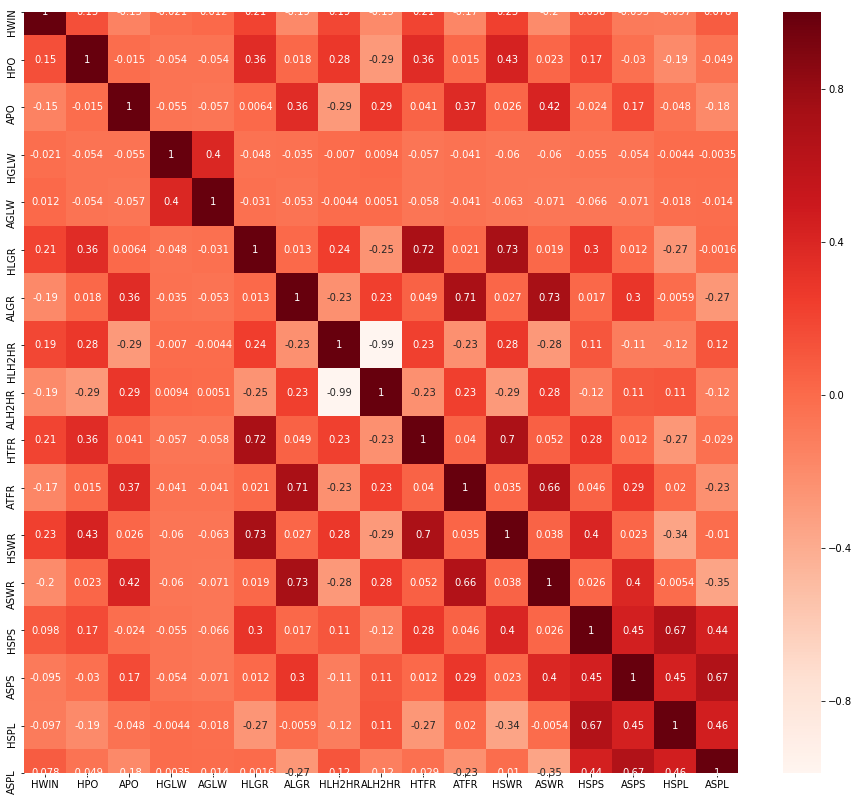

Features prepared for model: Index(['HPO', 'APO', 'HLGR', 'ALGR', 'HLH2HR', 'ALH2HR', 'HTFR', 'ATFR',
       'HSWR', 'ASWR'],
      dtype='object')


In [11]:
# use Pearson correlation to determine what features have best correlation with label
plt.figure(figsize=(16,14))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# correlation with label variable
cor_target = abs(cor['HWIN'])

# select correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

# create list with relevant features
features=relevant_features.keys()[1:]
#features=['HPO', 'APO', 'HLGR', 'ALGR', 'HLH2HR', 'ALH2HR', 'HTFR', 'ATFR', 'HSWR', 'ASWR', 'HSPS', 'HSPL', 'ASPS', 'ASPL']
print ("Features prepared for model: {}".format(features))

In [12]:
X = X[features]
X.head()

,HPO,APO,HLGR,ALGR,HLH2HR,ALH2HR,HTFR,ATFR,HSWR,ASWR
0,0.0625,0.0164,0.6,0.5,0.750000,0.250000,0.4,0.6,0.557,0.563
1,0.0909,0.0050,0.7,0.5,1.000000,0.000000,1.0,0.3,0.678,0.448
2,0.0244,0.0244,0.0,0.3,0.333333,0.666667,0.4,0.2,0.383,0.383
3,0.0132,0.0244,0.2,0.4,0.400000,0.600000,0.2,0.1,0.261,0.273
4,0.1111,0.1111,0.7,0.7,0.500000,0.500000,0.8,0.6,0.667,0.667


In [13]:
# create neural network model

dim = len(features)

model = Sequential()
model.add(Dense(dim, input_dim=dim, activation='relu'))
model.add(Dense(2, activation='softmax'))
sgd = optimizers.SGD(lr=0.2, decay=1e-6, momentum=0.1, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# standarizing data

scaler = StandardScaler()
scaled_X= scaler.fit_transform(X)

# encode label values

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.1)

In [16]:
# fit model with prepared data

history = model.fit(X_train, y_train, epochs=20, batch_size=1000)


Epoch 1/20
22032/22032 [==============================] - 0s 15us/step - loss: 0.8972 - accuracy: 0.3998
Epoch 2/20
22032/22032 [==============================] - 0s 4us/step - loss: 0.7883 - accuracy: 0.3945
Epoch 3/20
22032/22032 [==============================] - 0s 5us/step - loss: 0.7269 - accuracy: 0.3787
Epoch 4/20
22032/22032 [==============================] - 0s 4us/step - loss: 0.6959 - accuracy: 0.5329
Epoch 5/20
22032/22032 [==============================] - 0s 5us/step - loss: 0.6805 - accuracy: 0.5965
Epoch 6/20
22032/22032 [==============================] - 0s 6us/step - loss: 0.6702 - accuracy: 0.5999
Epoch 7/20
22032/22032 [==============================] - 0s 4us/step - loss: 0.6610 - accuracy: 0.6019
Epoch 8/20
22032/22032 [==============================] - 0s 4us/step - loss: 0.6527 - accuracy: 0.6149
Epoch 9/20
22032/22032 [==============================] - 0s 4us/step - loss: 0.6451 - accuracy: 0.6276
Epoch 10/20
22032/22032 [==============================] - 0s 

In [17]:
# evaluating the model with test data

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2448/2448 [==============================] - 0s 53us/step
accuracy: 66.05%


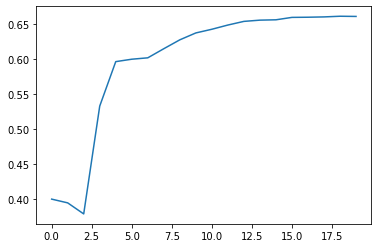

In [18]:
plt.plot(history.history['accuracy'])

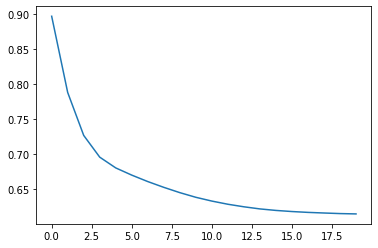

In [19]:
plt.plot(history.history['loss'])

In [20]:
# serialize model to json
model2json = model.to_json()
f = open(os.path.expanduser("~/nba-dl/models/model-1.json"), "w+")
f.write(model2json)
f.close()

# save weights
model.save_weights(os.path.expanduser('~/nba-dl/models/model-1-weights.h5'))

# save input features
with open(os.path.expanduser("~/nba-dl/models/model-1-features.pickle"), "wb+") as f:
    pickle.dump(features, f)